Data from https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database/data

In [1]:
# !pip install oracledb

In [14]:
import oracledb
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import json

from IPython.display import display
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.feature_extraction import DictVectorizer

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Data was uploaded to Oracle Database and fetched to show off SQL skills

In [2]:
def connect_oracle():
    password = 'password'
    connection=oracledb.connect(
         config_dir="/opt/oracle/instantclient_21_12/network/admin",
         user="user",
         password=password,
         dsn="dsn_low",
         wallet_location="/opt/oracle/instantclient_21_12/network/admin",
         wallet_password=password)
    return connection

In [3]:
def Run_Query_Function(query):
    # Create a cursor object
    connection = connect_oracle()
    cursor = connection.cursor()
    
    # Execute a query
    cursor.execute(query)
    
    # Fetch the results
    results = cursor.fetchall()
    
    # Get the column names
    column_names = [i[0] for i in cursor.description]
    
    # Create a DataFrame from the results
    dataframe = pd.DataFrame(results, columns=column_names)
    
    # Close the cursor and connection
    cursor.close()
    connection.close()

    return dataframe


In [6]:
##Distinct Anime Names

Run_Query_Function('''
    SELECT COUNT(DISTINCT A.NAME)
    FROM ANIME A
    ''')

,COUNT(DISTINCTA.NAME)
0,12292


In [5]:
#Anime Rating Distribution
Run_Query_Function('''
    SELECT cast(ROUND(A.RATING,0) as int) AS RATING_NUM,COUNT(A.ANIME_ID)
    FROM ANIME A
    WHERE A.RATING IS NOT NULL
    GROUP BY cast(ROUND(A.RATING,0) as int)
    ORDER BY cast(ROUND(A.RATING,0) as int)
    ''')

,RATING_NUM,COUNT(A.ANIME_ID)
0,2,6
1,3,79
2,4,445
3,5,1400
4,6,3712
5,7,4669
6,8,1616
7,9,134
8,10,3


In [8]:
#Unique Anime Ids where rating is null
Run_Query_Function('''
    SELECT COUNT(A.ANIME_ID)
    FROM ANIME A
    WHERE A.RATING IS NULL
    ''')

,COUNT(A.ANIME_ID)
0,230


In [9]:
#Unique Anime types and their distribution
Run_Query_Function('''
    SELECT A.TYPE,COUNT(A.ANIME_ID)
    FROM ANIME A
    GROUP BY A.TYPE
    ORDER BY A.TYPE
 ''')

,TYPE,COUNT(A.ANIME_ID)
0,Movie,2348
1,Music,488
2,ONA,659
3,OVA,3311
4,Special,1676
5,TV,3787
6,None,25


In [44]:
#mature Anime
Run_Query_Function('''
    SELECT COUNT(A.ANIME_ID)
    FROM ANIME A
    WHERE LOWER(A.GENRE) LIKE 'hentai%'
 ''')

,COUNT(A.ANIME_ID)
0,947


In [10]:
Anime_Ratings_Data = Run_Query_Function('''
    SELECT A.ANIME_ID AS ANIME_ANIME_ID, 
        A.NAME, 
        A.GENRE, 
        A.TYPE, 
        A.EPISODES, 
        A.RATING AS ANIME_RATING, 
        A.MEMBERS
    FROM ANIME A
    WHERE A.RATING IS NOT NULL
    AND LOWER(A.GENRE) NOT LIKE 'hentai%'
    AND  A.TYPE IS NOT NULL
    ''')

In [11]:
Anime_Ratings_Data.columns

Index(['ANIME_ANIME_ID', 'NAME', 'GENRE', 'TYPE', 'EPISODES', 'ANIME_RATING',
       'MEMBERS'],
      dtype='object')

In [13]:
n_anime = len(Anime_Ratings_Data.ANIME_ANIME_ID.unique())
print("Number of unique anime:", n_anime)
print("--------------------")

Number of unique anime: 11077
--------------------


In [76]:
# Anime_Ratings_Data.to_csv("Anime_Ratings_Data.csv")

In [30]:
df = Anime_Ratings_Data

In [31]:
print(len(df))

11077


In [32]:
display(df.head().T)

,0,1,2,3,4
ANIME_ANIME_ID,22117,27887,4943,14117,2964
NAME,Witch Craft Works OVA,Yama no Susume Second Season Specials,Yousei Florence,Blood-C: Special Edition,Blue Drop: Tenshi-tachi no Gikyoku
GENRE,"Action, Fantasy, Seinen, Supernatural","Comedy, Slice of Life","Adventure, Fantasy, Music","Action, Horror, School, Supernatural, Vampire","Drama, Sci-Fi, Shoujo Ai"
TYPE,OVA,Special,Movie,Special,TV
EPISODES,1,2,1,2,13
ANIME_RATING,6.89,6.89,6.89,6.88,6.88
MEMBERS,13727,2939,891,6993,19968


In [33]:
print(df.dtypes)

ANIME_ANIME_ID      int64
NAME               object
GENRE              object
TYPE               object
EPISODES           object
ANIME_RATING      float64
MEMBERS             int64
dtype: object


In [34]:
print(df.columns)

Index(['ANIME_ANIME_ID', 'NAME', 'GENRE', 'TYPE', 'EPISODES', 'ANIME_RATING',
       'MEMBERS'],
      dtype='object')


In [35]:
columns_filtered = ['NAME', 'GENRE', 'TYPE', 'EPISODES', 'ANIME_RATING','MEMBERS']

In [36]:
df = df[columns_filtered]
display(df.head().T)

,0,1,2,3,4
NAME,Witch Craft Works OVA,Yama no Susume Second Season Specials,Yousei Florence,Blood-C: Special Edition,Blue Drop: Tenshi-tachi no Gikyoku
GENRE,"Action, Fantasy, Seinen, Supernatural","Comedy, Slice of Life","Adventure, Fantasy, Music","Action, Horror, School, Supernatural, Vampire","Drama, Sci-Fi, Shoujo Ai"
TYPE,OVA,Special,Movie,Special,TV
EPISODES,1,2,1,2,13
ANIME_RATING,6.89,6.89,6.89,6.88,6.88
MEMBERS,13727,2939,891,6993,19968


## Data Cleaning

In [37]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [38]:
display(df.head().T)

,0,1,2,3,4
name,witch_craft_works_ova,yama_no_susume_second_season_specials,yousei_florence,blood-c:_special_edition,blue_drop:_tenshi-tachi_no_gikyoku
genre,"action,_fantasy,_seinen,_supernatural","comedy,_slice_of_life","adventure,_fantasy,_music","action,_horror,_school,_supernatural,_vampire","drama,_sci-fi,_shoujo_ai"
type,ova,special,movie,special,tv
episodes,1,2,1,2,13
anime_rating,6.89,6.89,6.89,6.88,6.88
members,13727,2939,891,6993,19968


In [39]:
# Apply the list to to the 'genre' column
df['genre_list'] = df['genre'].apply(lambda x: x.split(","))

# Convert the 'episodes' column to a numeric type (float)
df['episodes'] = df['episodes'].replace('unknown', '0', regex=True).astype(float)

In [40]:
display(df.head().T)

,0,1,2,3,4
name,witch_craft_works_ova,yama_no_susume_second_season_specials,yousei_florence,blood-c:_special_edition,blue_drop:_tenshi-tachi_no_gikyoku
genre,"action,_fantasy,_seinen,_supernatural","comedy,_slice_of_life","adventure,_fantasy,_music","action,_horror,_school,_supernatural,_vampire","drama,_sci-fi,_shoujo_ai"
type,ova,special,movie,special,tv
episodes,1.0,2.0,1.0,2.0,13.0
anime_rating,6.89,6.89,6.89,6.88,6.88
members,13727,2939,891,6993,19968
genre_list,"[action, _fantasy, _seinen, _supernatural]","[comedy, _slice_of_life]","[adventure, _fantasy, _music]","[action, _horror, _school, _supernatural, _vam...","[drama, _sci-fi, _shoujo_ai]"


In [41]:
df['members'] = pd.to_numeric(df['members'])
df['anime_rating'] = pd.to_numeric(df['anime_rating'])
df['episodes'] = pd.to_numeric(df['episodes'])

In [42]:
# Convert all genres to lowercase to avoid case sensitivity issues
df['genre_list'] = df['genre_list'].apply(lambda x: [genre.lower() for genre in x])

# Get the unique list of all possible genre
all_genres = set(genre for sublist in df['genre_list'] for genre in sublist)

# Now create binary columns for each genre
for genre in all_genres:
    # Create a new column for each genre
    df[genre] = df['genre_list'].apply(lambda x: 1 if genre in x else 0)

In [43]:
display(df.head().T)

,0,1,2,3,4
name,witch_craft_works_ova,yama_no_susume_second_season_specials,yousei_florence,blood-c:_special_edition,blue_drop:_tenshi-tachi_no_gikyoku
genre,"action,_fantasy,_seinen,_supernatural","comedy,_slice_of_life","adventure,_fantasy,_music","action,_horror,_school,_supernatural,_vampire","drama,_sci-fi,_shoujo_ai"
type,ova,special,movie,special,tv
episodes,1.0,2.0,1.0,2.0,13.0
anime_rating,6.89,6.89,6.89,6.88,6.88
...,...,...,...,...,...
_thriller,0,0,0,0,0
_yaoi,0,0,0,0,0
fantasy,0,0,0,0,0
drama,0,0,0,0,1


## Exploratory data analysis

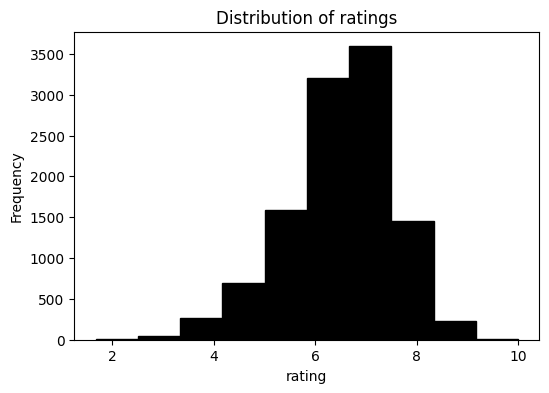

In [44]:
plt.figure(figsize=(6, 4))

sns.histplot(df.anime_rating.values, bins=10, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('rating')
plt.title('Distribution of ratings')

plt.show()

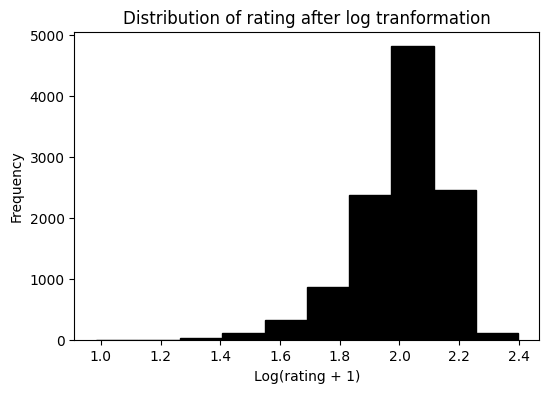

In [45]:
log_rating = np.log1p(df.anime_rating)

plt.figure(figsize=(6, 4))

sns.histplot(log_rating, bins=10, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(rating + 1)')
plt.title('Distribution of rating after log tranformation')

plt.show()

In [46]:
print(df.isnull().sum()[df.isnull().sum()>0])

Series([], dtype: int64)


In [47]:
df = df.dropna()

In [48]:
print(df.isnull().sum()[df.isnull().sum()>0])

Series([], dtype: int64)


In [49]:
print(df.dtypes)

name             object
genre            object
type             object
episodes        float64
anime_rating    float64
                 ...   
_thriller         int64
_yaoi             int64
fantasy           int64
drama             int64
martial_arts      int64
Length: 88, dtype: object


In [50]:
df.columns

Index(['name', 'genre', 'type', 'episodes', 'anime_rating', 'members',
       'genre_list', '_school', '_game', 'school', '_shounen', '_horror',
       '_supernatural', '_slice_of_life', '_historical', '_fantasy', 'ecchi',
       'slice_of_life', 'historical', '_shoujo_ai', '_romance', 'military',
       '_ecchi', '_military', '_shoujo', '_shounen_ai', '_comedy', 'harem',
       'yaoi', '_cars', '_demons', 'samurai', '_music', '_kids', 'super_power',
       '_yuri', '_dementia', 'comedy', '_seinen', 'dementia', 'game', 'shoujo',
       'mystery', '_mystery', '_vampire', 'josei', '_hentai', 'mecha',
       '_sports', '_sci-fi', '_magic', '_parody', 'action', 'thriller',
       '_super_power', '_police', 'adventure', 'seinen', 'music', 'police',
       'space', 'magic', 'demons', '_harem', '_drama', 'cars', 'parody',
       'sports', 'kids', '_martial_arts', 'supernatural', '_samurai', 'sci-fi',
       'romance', 'psychological', '_space', '_mecha', 'horror', '_adventure',
       '_josei

## Feature Importance

In [55]:
categorical = ['name', 'type', '_school', '_game', 'school', '_shounen', '_horror',
       '_supernatural', '_slice_of_life', '_historical', '_fantasy', 'ecchi',
       'slice_of_life', 'historical', '_shoujo_ai', '_romance', 'military',
       '_ecchi', '_military', '_shoujo', '_shounen_ai', '_comedy', 'harem',
       'yaoi', '_cars', '_demons', 'samurai', '_music', '_kids', 'super_power',
       '_yuri', '_dementia', 'comedy', '_seinen', 'dementia', 'game', 'shoujo',
       'mystery', '_mystery', '_vampire', 'josei', '_hentai', 'mecha',
       '_sports', '_sci-fi', '_magic', '_parody', 'action', 'thriller',
       '_super_power', '_police', 'adventure', 'seinen', 'music', 'police',
       'space', 'magic', 'demons', '_harem', '_drama', 'cars', 'parody',
       'sports', 'kids', '_martial_arts', 'supernatural', '_samurai', 'sci-fi',
       'romance', 'psychological', '_space', '_mecha', 'horror', '_adventure',
       '_josei', 'vampire', '_psychological', 'shounen', '_thriller', '_yaoi',
       'fantasy', 'drama', 'martial_arts']
numerical = ['episodes', 'members']

In [56]:

# Pre-process the categorical columns
label_encoders = {}
for column in categorical:
    le = LabelEncoder()
    # Fill NaN with a placeholder string and convert to type str to ensure all data is of the same type
    df[column] = df[column].fillna('Unknown').astype(str)
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

def calculate_mi(series):
    return round(mutual_info_score(series, df.anime_rating), 2)

# Now apply the calculate_mi function
df_mi = df[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

display(df_mi.head(10))
display(df_mi.tail())


,MI
name,5.96
type,0.22
_shounen,0.06
_drama,0.05
action,0.05
_romance,0.05
_fantasy,0.04
dementia,0.04
_sci-fi,0.04
kids,0.04


,MI
samurai,0.0
super_power,0.0
thriller,0.0
shoujo,0.0
martial_arts,0.0


In [57]:
df[numerical].corrwith(df.anime_rating).to_frame('correlation')

,correlation
episodes,0.085299
members,0.390300


In [58]:
display(df[numerical].corr())

,episodes,members
episodes,1.000000,0.051056
members,0.051056,1.000000


### Linear Regression

In [59]:
df['anime_rating_log'] = np.log1p(df['anime_rating'])
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
y_train = df_train.anime_rating_log.values
y_val = df_val.anime_rating_log.values
y_test = df_test.anime_rating_log.values

del df_train['anime_rating_log']
del df_val['anime_rating_log']
del df_test['anime_rating_log']

del df_train['anime_rating']
del df_val['anime_rating']
del df_test['anime_rating']



In [60]:
# List of alpha values to try
alphas = [0, 0.01, 0.1, 1, 10]
# Dictionary to store RMSE scores for each alpha
rmse_scores = {}

for alpha in alphas:
    # Create and fit the Ridge regression model
    model = Ridge(alpha=alpha, solver='sag', random_state=42)
    train_dict = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    model.fit(X_train, y_train)
    
    
    test_dict = df_test[categorical + numerical].to_dict(orient='records')
    X_test = dv.transform(test_dict)
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate RMSE and round it to 3 decimal places
    rmse = round(np.sqrt(((y_pred - y_test) ** 2).mean()), 10)
    
    # Store RMSE in the dictionary
    rmse_scores[alpha] = rmse

# Display the RMSE scores for different alpha values
for alpha, rmse in rmse_scores.items():
    print(f"Alpha={alpha}: RMSE={rmse}")

Alpha=0: RMSE=0.1333897087
Alpha=0.01: RMSE=0.1333897087
Alpha=0.1: RMSE=0.1333897087
Alpha=1: RMSE=0.1333897087
Alpha=10: RMSE=0.1333897087


## Decision Tree

In [61]:
dict_train = df_train[categorical + numerical].to_dict(orient='records')
dict_val = df_val[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

In [62]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [63]:
y_pred = dt.predict(X_train)
print("On Training :" , np.sqrt(mean_squared_error(y_train, y_pred)))
y_pred = dt.predict(X_val)
print("On Testing :",np.sqrt(mean_squared_error(y_val, y_pred)))

On Training : 4.717950284575502e-18
On Testing : 0.13404160943216534


In [64]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_train)
RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
print('On Training RMSE: %.3f' % RMSE)

y_pred = dt.predict(X_val)
RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
print('On Testing RMSE: %.3f' % RMSE)

On Training RMSE: 0.125
On Testing RMSE: 0.128


## Random forest

In [65]:
rf = RandomForestRegressor(n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(np.sqrt(mean_squared_error(y_val, y_pred)))

0.1039490274749207


In [66]:
RMSES = []

for i in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=i, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
    print('%s -> %.3f' % (i, RMSE))
    RMSES.append(RMSE)

10 -> 0.104
20 -> 0.102
30 -> 0.101
40 -> 0.101
50 -> 0.101
60 -> 0.101
70 -> 0.100
80 -> 0.100
90 -> 0.100
100 -> 0.100
110 -> 0.100
120 -> 0.100
130 -> 0.100
140 -> 0.100
150 -> 0.100
160 -> 0.100
170 -> 0.100
180 -> 0.100
190 -> 0.100
200 -> 0.100


Tuinnig the `max_depth` parameter:

In [67]:
all_RMSES = {}

for depth in [40, 80, 100]:
    print('depth: %s' % depth)
    RMSES = []

    for i in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=i, max_depth=depth, random_state=1,n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        RMSE =  np.sqrt(mean_squared_error(y_val, y_pred))
        print('%s -> %.3f' % (i, RMSE))
        RMSES.append(RMSE)
    
    all_RMSES[depth] = RMSES
    print()
    

depth: 40
10 -> 0.104
20 -> 0.102
30 -> 0.101
40 -> 0.101
50 -> 0.101
60 -> 0.101
70 -> 0.100
80 -> 0.100
90 -> 0.100
100 -> 0.100
110 -> 0.100
120 -> 0.100
130 -> 0.100
140 -> 0.100
150 -> 0.100
160 -> 0.100
170 -> 0.100
180 -> 0.100
190 -> 0.100
200 -> 0.100

depth: 80
10 -> 0.104
20 -> 0.102
30 -> 0.101
40 -> 0.101
50 -> 0.101
60 -> 0.101
70 -> 0.100
80 -> 0.100
90 -> 0.100
100 -> 0.100
110 -> 0.100
120 -> 0.100
130 -> 0.100
140 -> 0.100
150 -> 0.100
160 -> 0.100
170 -> 0.100
180 -> 0.100
190 -> 0.100
200 -> 0.100

depth: 100
10 -> 0.104
20 -> 0.102
30 -> 0.101
40 -> 0.101
50 -> 0.101
60 -> 0.101
70 -> 0.100
80 -> 0.100
90 -> 0.100
100 -> 0.100
110 -> 0.100
120 -> 0.100
130 -> 0.100
140 -> 0.100
150 -> 0.100
160 -> 0.100
170 -> 0.100
180 -> 0.100
190 -> 0.100
200 -> 0.100



In [68]:
rf = RandomForestRegressor(n_estimators=80 , max_depth=40, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=40, n_estimators=80, n_jobs=-1, random_state=1)

In [69]:
y_pred_rf = rf.predict(X_val)
RMSE =  np.sqrt(mean_squared_error(y_val, y_pred))
print('%.3f' % (RMSE))

0.100


[2.55757625e-03 1.24777304e-03 4.44264468e-03 4.60661446e-03
 1.70318926e-03 4.48318195e-03 4.83156136e-03 6.22239225e-03
 1.13636405e-03 1.28804645e-03 6.60935040e-03 6.10569849e-03
 4.65633325e-03 2.78202640e-04 1.14861149e-02 3.22171994e-03
 2.08248521e-03 5.22085011e-03 1.90845585e-03 5.55662466e-03
 2.19846617e-03 3.07244085e-03 1.89946569e-03 1.92070333e-03
 2.45953705e-03 1.64771359e-03 3.16323248e-03 4.65229756e-03
 2.22706887e-03 2.38135345e-03 2.11958325e-04 1.07643858e-02
 5.39539184e-04 6.30919377e-03 2.64953348e-03 4.36990292e-03
 2.35427856e-03 3.55700596e-03 6.13907888e-04 1.02516969e-03
 3.02206115e-04 1.38396778e-04 8.40390383e-03 6.64444088e-03
 8.35342349e-04 1.16580828e-02 2.26444976e-02 1.30662291e-03
 1.47689847e-02 1.07663215e-03 6.57004672e-02 4.88497186e-03
 7.48506607e-04 1.63369998e-04 4.84059475e-03 3.59871231e-03
 1.04678000e-05 5.04659197e-03 1.00393576e-03 3.19992709e-06
 1.26413969e-03 5.22297718e-01 2.43708420e-04 2.18829471e-03
 3.17742007e-04 1.138811

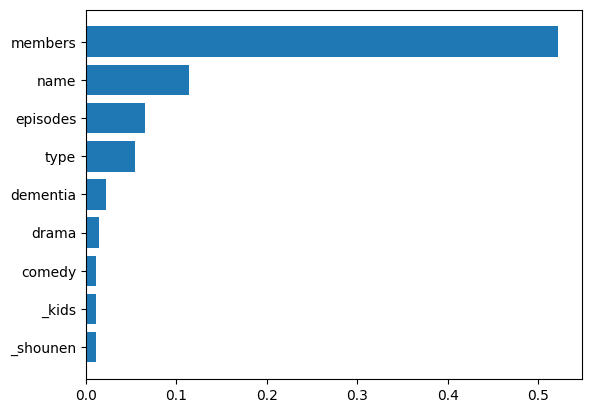

In [70]:
print(rf.feature_importances_)
importances = list(zip(dv.feature_names_, rf.feature_importances_))

df_importance = pd.DataFrame(importances, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)
print(df_importance)
df_importance = df_importance[df_importance.gain > 0.01]
num = len(df_importance)
plt.barh(range(num), df_importance.gain[::-1])
plt.yticks(range(num), df_importance.feature[::-1])

plt.show()

## XGBoost

In [71]:
cleaned_feature_names = dv.feature_names_

In [72]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=cleaned_feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=cleaned_feature_names)

In [73]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred = model.predict(dval)
print(np.sqrt(mean_squared_error(y_val, y_pred)))

0.10216752958746898


In [74]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,
    'eval_metric': 'rmse',

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

[0]	train-rmse:0.12852	val-rmse:0.13155
[10]	train-rmse:0.09117	val-rmse:0.10162
[20]	train-rmse:0.08458	val-rmse:0.10040
[30]	train-rmse:0.08013	val-rmse:0.10025
[40]	train-rmse:0.07729	val-rmse:0.10025
[50]	train-rmse:0.07455	val-rmse:0.10080
[60]	train-rmse:0.07161	val-rmse:0.10089
[70]	train-rmse:0.06853	val-rmse:0.10116
[80]	train-rmse:0.06426	val-rmse:0.10202
[90]	train-rmse:0.06239	val-rmse:0.10197
[99]	train-rmse:0.06090	val-rmse:0.10217
